In [ ]:
# !pip install astroML 

     |████████████████████████████████| 112kB 6.6MB/s 
  Created wheel for astroML: filename=astroML-0.4.1-cp36-none-any.whl size=128665 sha256=355b94db407660c6e83da4e592bcb6e39a3138013dc87d5d4e6744119831dac6
  Stored in directory: /root/.cache/pip/wheels/7c/f2/f3/eb817cfb31b4445358dd7dda2434e02003f72801edabc38c97
Successfully built astroML


In [ ]:
from astroML.datasets import fetch_imaging_sample
from astroML.plotting import scatter_contour
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV


# Problema
SDSS genera datos fotométricos de miles de objetos por noche. Todos estos objetos son estrellas o galaxias. Poder clasificarlos de manera automática seria de gran ayuda porque son tantos objetos que una clasificación a mano seria muy ineficiente. Además, esta clasificación permitiría facilitar la recopilación de datos. Por ejemplo, si algún astrónomo desea hacer algún estudio estadístico sobre galaxias, entonces lo mejor seria que pudiera obtener una muestra de solo galaxias. 


#### Objetivo: **Usar la información fotométrica de SDSS para clasificar los objetos entre estrellas y galaxias.**

# Obtención de datos
Los datos los estoy obteniendo del proyecto directamente. SDSS publica todos los datos que genera en internet para que cualquier persona con una computadora y acceso a internet los pueda utilizar. Aquí específicamente estoy usando una función para obtener las datos de casi 300,000 objetos y luego la reorganizo para facilitar su uso.

In [ ]:
data = fetch_imaging_sample()


In [ ]:
N_of_data_entries = data.shape[0]
N_of_data_features = len(data.dtype.names[:])
feature_names = data.dtype.names[:]
my_data = np.zeros((N_of_data_entries, N_of_data_features))

for entry in np.arange(N_of_data_entries):
    for feature in np.arange(N_of_data_features):
        my_data[entry][feature] = data[feature_names[feature]][entry][0]



# Exploración
Generalmente este paso es largo, y requiere de una inspección minusiosa de los datos obtenidos. Incluso se pueden realizar algunos análisis estadísticos preliminares. Para mantenerlo simple, solo quiero que miremos los datos que obtuvimos y que los intentemos entender.

In [ ]:
my_data_pd = pd.DataFrame(my_data, columns=list(feature_names))
my_data_pd.head(10)


,ra,dec,run,rExtSFD,uRaw,gRaw,rRaw,iRaw,zRaw,uErr,gErr,rErr,iErr,zErr,uRawPSF,gRawPSF,rRawPSF,iRawPSF,zRawPSF,upsfErr,gpsfErr,rpsfErr,ipsfErr,zpsfErr,type,ISOLATED
0,0.358174,-0.508718,2728.0,0.103,23.255,22.633,22.459,21.911,21.211,0.487,0.126,0.145,0.129,0.264,23.028,22.621,22.563,22.039,21.240,0.378,0.164,0.140,0.125,0.248,3.0,1.0
1,0.358382,-0.551157,2728.0,0.107,25.302,22.345,20.589,18.896,17.984,0.711,0.097,0.031,0.013,0.020,24.989,22.347,20.617,18.896,17.976,0.793,0.094,0.038,0.035,0.038,6.0,0.0
2,0.357898,-0.570892,2728.0,0.109,23.025,22.317,21.350,21.057,20.890,0.670,0.159,0.103,0.117,0.359,23.701,22.919,22.260,21.932,21.797,0.611,0.148,0.111,0.115,0.379,3.0,1.0
3,0.357910,-0.426526,2728.0,0.100,23.190,22.398,20.941,19.967,19.506,0.453,0.101,0.040,0.026,0.059,23.020,22.333,20.907,19.930,19.515,0.382,0.102,0.045,0.035,0.070,6.0,0.0
4,0.358881,-0.505625,2728.0,0.103,23.495,24.024,21.378,20.504,20.117,0.697,0.469,0.074,0.049,0.131,23.526,24.089,21.802,20.957,20.384,0.613,0.330,0.075,0.054,0.123,3.0,0.0
5,0.162688,-0.590807,2728.0,0.117,25.415,22.606,21.748,21.440,20.861,1.098,0.198,0.135,0.152,0.329,25.364,23.147,22.473,22.167,21.498,0.678,0.181,0.134,0.144,0.306,3.0,1.0
6,0.142353,-0.613267,2728.0,0.117,24.530,23.264,20.734,20.029,19.588,1.285,0.312,0.051,0.041,0.098,24.612,23.533,21.357,20.670,20.145,0.849,0.257,0.053,0.044,0.100,3.0,0.0
7,0.142009,-0.585848,2728.0,0.116,25.743,22.914,21.116,20.509,20.179,0.621,0.179,0.055,0.047,0.126,25.496,23.104,21.427,20.791,20.381,0.625,0.174,0.057,0.047,0.122,3.0,1.0
8,0.121992,-0.462113,2728.0,0.112,21.711,21.319,20.488,20.490,19.806,0.412,0.127,0.096,0.202,0.272,23.509,22.801,22.362,22.437,21.610,0.554,0.133,0.119,0.179,0.324,3.0,1.0
9,0.221928,-0.515993,2728.0,0.112,20.814,19.541,18.999,18.781,18.711,0.069,0.013,0.011,0.012,0.032,20.804,19.544,18.981,18.803,18.707,0.065,0.022,0.017,0.019,0.036,6.0,1.0


# Preparación de Datos
Aquí deseo preparar los datos para ponerlos en un formato que sea útil para el algoritmo que usemos. Para empezar, escogemos que variables son útiles, y me quedo con solo las magnitudes puesto que son la pieza de información mas relevante. Tambien realizo una resta de las magnitudes normales y las PSF (Función de dispersión de punto como medición de que tan parecido es un punto a cada obeto) en cada una de las cinco bandas.

In [ ]:
# add the extra columns
my_data_pd['uDiff'] = my_data_pd['uRaw'] - my_data_pd['uRawPSF']
my_data_pd['gDiff'] = my_data_pd['gRaw'] - my_data_pd['gRawPSF']
my_data_pd['rDiff'] = my_data_pd['rRaw'] - my_data_pd['rRawPSF']
my_data_pd['iDiff'] = my_data_pd['iRaw'] - my_data_pd['iRawPSF']
my_data_pd['zDiff'] = my_data_pd['zRaw'] - my_data_pd['zRawPSF']


In [ ]:
my_data_pd[['uDiff', 'gDiff', 'rDiff', 'iDiff', 'zDiff', 'type']].head(10)


,uDiff,gDiff,rDiff,iDiff,zDiff,type
0,0.227,0.012,-0.104,-0.128,-0.029,3.0
1,0.313,-0.002,-0.028,0.000,0.008,6.0
2,-0.676,-0.602,-0.910,-0.875,-0.907,3.0
3,0.170,0.065,0.034,0.037,-0.009,6.0
4,-0.031,-0.065,-0.424,-0.453,-0.267,3.0
5,0.051,-0.541,-0.725,-0.727,-0.637,3.0
6,-0.082,-0.269,-0.623,-0.641,-0.557,3.0
7,0.247,-0.190,-0.311,-0.282,-0.202,3.0
8,-1.798,-1.482,-1.874,-1.947,-1.804,3.0
9,0.010,-0.003,0.018,-0.022,0.004,6.0


Por último, separamos los datos en un set de entrenamiento (usado para que el algoritmo "aprenda") y un set de evaluación.

In [ ]:
# first we separate the entire data set into training and test, using stratified splitter
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(my_data_pd, my_data_pd["type"]):
    strat_train_set = my_data_pd.loc[train_index]
    strat_test_set = my_data_pd.loc[test_index]

# now separate the training data set into feaures and labels
X_train = strat_train_set[['uDiff', 'gDiff', 'rDiff', 'iDiff', 'zDiff']].values
Y_train = strat_train_set['type'].values

# now separate the training data set into feaures and labels
X_test = strat_test_set[['uDiff', 'gDiff', 'rDiff', 'iDiff', 'zDiff']].values
Y_test = strat_test_set['type'].values

y_train = Y_train == 3.0 # 1 if its star, 0 if its galaxy
y_test = Y_test == 3.0 # 1 if its star, 0 if its galaxy


# Entrenamiento de Algoritmo
Generalmente se seleccionan varios algoritmos que puedan realizar la misma tarea (clasificación en este caso). Aquí escogí el **"k-Nearest Neighbors"** (k vecinos más próximos) que es un algoritmo que usa la distancia entre puntos en el espacio de variables para realizar una clasificación. 

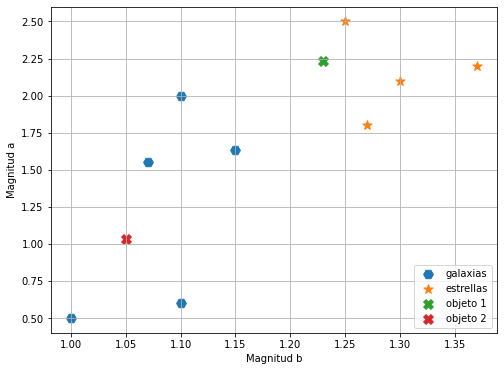

In [ ]:
xgalex = [1,1.1,1.1, 1.15, 1.07]
ygalex = [0.5,2,0.6, 1.635, 1.55]

xstarex = [1.3,1.37,1.25,1.27]
ystarex = [2.1,2.2,2.5, 1.8]

xobjex1 = [1.23]
yobjex1 = [2.23]

xobjex2 = [1.05]
yobjex2 = [1.03]

s1 = 95

plt.figure(figsize=(8, 6))
plt.scatter(xgalex, ygalex, marker='H', s=s1, label='galaxias')
plt.scatter(xstarex, ystarex, marker='*', s=s1, label='estrellas')
plt.scatter(xobjex1, yobjex1, marker='X', s=s1, label='objeto 1')
plt.scatter(xobjex2, yobjex2, marker='X', s=s1, label='objeto 2')
plt.ylabel('Magnitud a')
plt.xlabel('Magnitud b')
plt.legend(loc='lower right')
plt.grid()


Entrenamiento del algoritmo usando la data preparada.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(weights='uniform', n_neighbors=9)
knn_clf.fit(X_train, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

# Evaluación
Existen maneras sofisticadas de evaluar el trabajo de un algoritmo, pero aquí simplemente hago que el algoritmo clasifique el set de evaluación y miro el porcentaje de objetos que acierta.

In [ ]:
knn_clf.score(X_test, y_test)

0.963492615379964

Como podemos apreciar, el algoritmo es muy bueno pues alcanzó un 96.3% de clasificaciones correctas. Aún así, me gustaría saber si lo podemos mejorar.

# Mejorar y repetir
Este paso también depende mucho del problema y de los resultados obtenidos hasta el momento. Realmente obtuvimos un buen porcentaje porque utilizamos la diferencia entre las magnitudes normales y las PSF (si solo hubieroms usado las magnitudes normales, hubiesemos el algoritmo solo habría acertado el 80.7%), pero podriamos tratar de mejorarlo aún mas cambiando el numero de "vecinos" que el algoritmo utiliza.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_neighbors': [5, 9]}]

knn_clf2 = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf2, param_grid, cv=2, verbose=3)
grid_search.fit(X_train, y_train)


Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] n_neighbors=5 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... n_neighbors=5, score=0.962, total=   8.6s
[CV] n_neighbors=5 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


[CV] ....................... n_neighbors=5, score=0.962, total=   8.6s
[CV] n_neighbors=9 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.3s remaining:    0.0s


[CV] ....................... n_neighbors=9, score=0.964, total=   9.8s
[CV] n_neighbors=9 ...................................................
[CV] ....................... n_neighbors=9, score=0.963, total=   9.9s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   37.0s finished


GridSearchCV(cv=2, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [5, 9]}], pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=3)

In [ ]:
grid_search.best_params_, grid_search.best_score_


({'n_neighbors': 9}, 0.9636510683970643)

# Conclusiones
Usando la diferencia entre magnitudes normales y "PSF", y entrenando un algoritmo kNN con 9 "vecinos" nos proporciona un clasificador que acierta el 96.4% de las veces. \